<a href="https://colab.research.google.com/github/rsadaphule/jhu-dnn/blob/main/Submission_3%F0%9F%8F%86%F0%9F%91%82Phonemes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/competitions/12jun23JH-phonemes/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:

!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 12jun23JH-phonemes        # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                     # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 12jun23JH-phonemes
100% 28.8M/28.8M [00:00<00:00, 125MB/s]
Using competition: 12jun23JH-phonemes
  teamId  teamName                  submissionDate       score    
--------  ------------------------  -------------------  -------  
10575553  Group 1                   2023-06-25 00:50:04  0.94380  
10586104  Team 7                    2023-06-25 00:47:50  0.94380  
10581086  Solomon Gruse             2023-06-24 19:06:35  0.94240  
10578465  Group 6 - JHU             2023-06-24 11:41:23  0.94140  
10580200  Group 12                  2023-06-24 21:56:11  0.93680  
10584180  Vincent Kowalski          2023-06-24 20:21:42  0.93160  
10579018  Team 3                    2023-06-24 22:25:21  0.93140  
10579455  Group 2                   2023-06-25 00:17:11  0.93100  
10578912  Harris Rose               2023-06-24 23:54:56  0.93040  
10576089  Kevin Key                 2023-06-24 02:25:47  0.93000  
10583830  yju

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 1.09 s, sys: 229 ms, total: 1.32 s
Wall time: 2.69 s


In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O

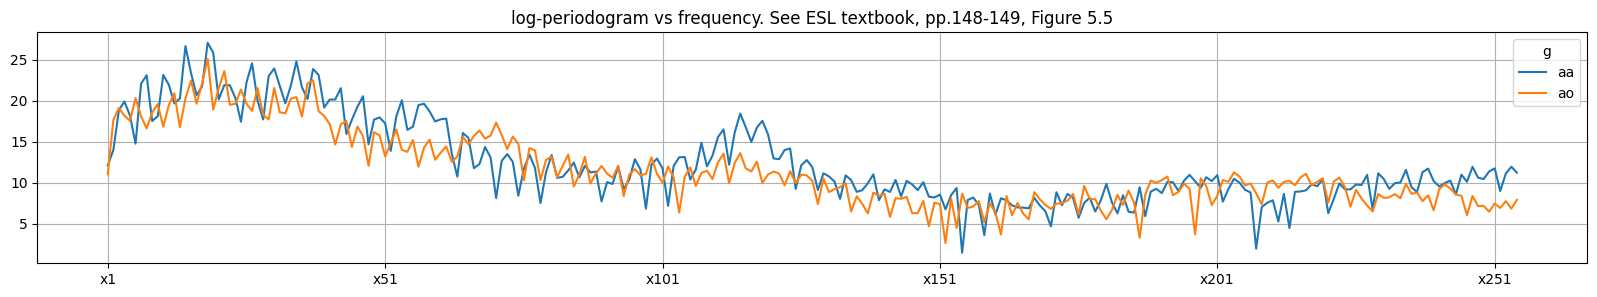

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**

Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

## Periodogram Processing

The features `(x1, ..., x256)` represent sound frequency bins, they measure how each phoneme impacts the frequency range. We also have a feature `SpkrID` which represents which speaker is uttering a given phoneme. We make the assumption each speaker has a base frequency response that is additive to the frequency response of each phoneme. For example, we can easily tell apart two people saying `ah` and still tell that they are both saying `ah`. This is due to `ah` being a unique change to some individual's baseline "voice". Which brings us to how we preprocess each of the periodograms.


1.   First, we calculate the median frequency response for each speaker in the dataset
2.   Second, we subtract each speakers median frequency response from every periodogram produced by that speaker


When running PCA with two components we see better clustering after this preprocessing step. Points are colored by what Phoneme the given signal represents.

<ipython-input-9-2491c6a24a28>:8: DtypeWarning: Columns (257) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('XY_Phonemes.csv')


Text(0.5, 1.0, 'PCA on Phenome Signals \n Before Preproc')

Text(0.5, 1.0, 'PCA on Phenome Signals \n After Preproc')

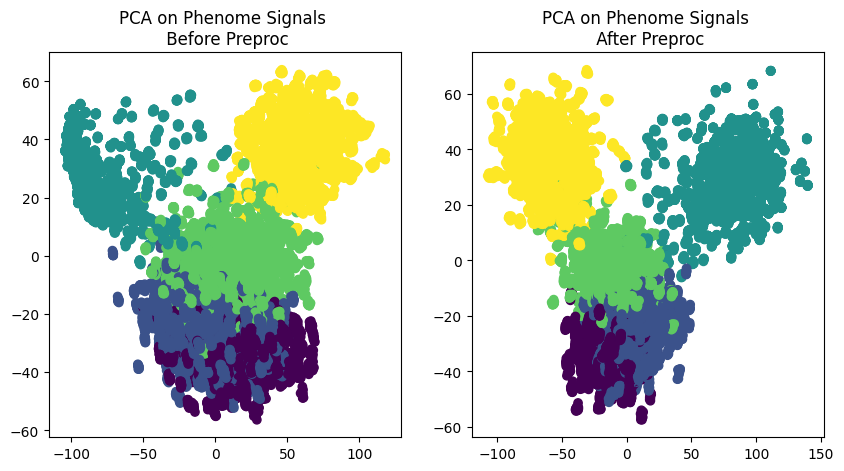

In [ ]:
#@title
# This code is specifically to generate visualizations to aid the description
# it's not used for generating the prediction

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('XY_Phonemes.csv')
df = df.query('g==g')

periodograms = df.drop(['g', 'SpkrID'], axis=1)

avg_speaker = {}

for spkr in df['SpkrID'].unique():
    avg_speaker[spkr] = periodograms[df['SpkrID'] == spkr].median(axis=0)

periodograms_speaker_removed = periodograms.copy()

for spkr in df['SpkrID'].unique():
    periodograms_speaker_removed[df['SpkrID'] == spkr] -= avg_speaker[spkr]

pre_embdeds = PCA(n_components=2).fit_transform(periodograms)
post_embeds = PCA(n_components=2).fit_transform(periodograms_speaker_removed)
lblr = LabelEncoder()

fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(pre_embdeds[:,0], pre_embdeds[:,1], c=lblr.fit_transform(df['g']))
ax[0].set_title('PCA on Phenome Signals \n Before Preproc')
ax[1].scatter(post_embeds[:,0], post_embeds[:,1], c=lblr.fit_transform(df['g']))
ax[1].set_title('PCA on Phenome Signals \n After Preproc')
plt.show()

## Generating Ideal Signals

Similar to creating "ideal" signals for each speaker we also create ideal signals for each phoneme.


1.   Using the training data we loop through each phoneme (`g`) and take the median values for each of the frequency bands `(x1, ..., x256)`
2.   Then we create new columns `aa_MSE`, `ao_MSE`, `dcl_MSE`, `sh_MSE`, and `iy_MSE` which measure the mean squared error for the given periodogram and each of the "ideal" signals for each class.

Below are the periodograms for each of our ideal signals for each class. As well as the boxplots for how well the MSE features separate each class. We can see in the boxplots that the MSE for the given class is on average always the lowest. Additionally, if we train a random forest with these features added to the full dataset they come out on top when doing feature importance. In fact, doing this preprocessing and adding the MSE features can get 0.9994 accuracy locally and 0.93 on the Kaggle public leaderboard with a random forest with default parameters.

Text(0.5, 1.0, 'Average Signal Per Phoneme \n Avg Speaker Signal Removed')

([], [])

([], [])

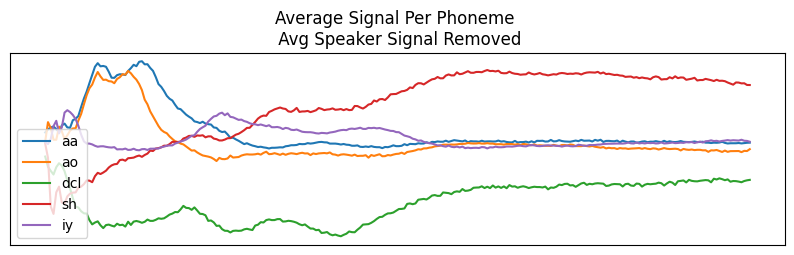

<Axes: xlabel='g', ylabel='aa_MSE'>

Text(0.5, 1.0, 'MSE aa')

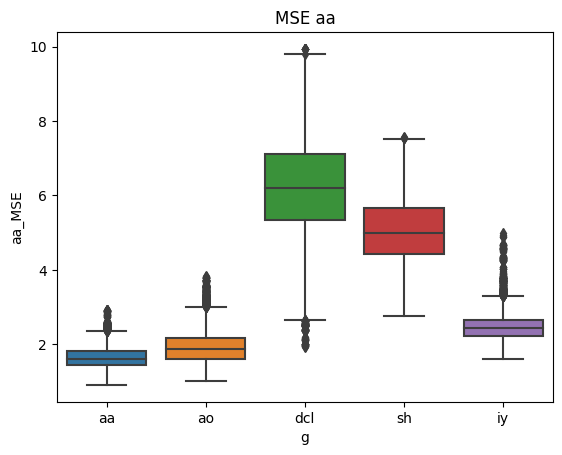

<Axes: xlabel='g', ylabel='ao_MSE'>

Text(0.5, 1.0, 'MSE ao')

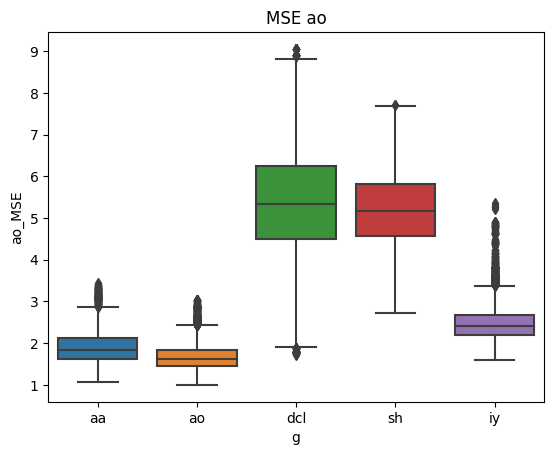

<Axes: xlabel='g', ylabel='dcl_MSE'>

Text(0.5, 1.0, 'MSE dcl')

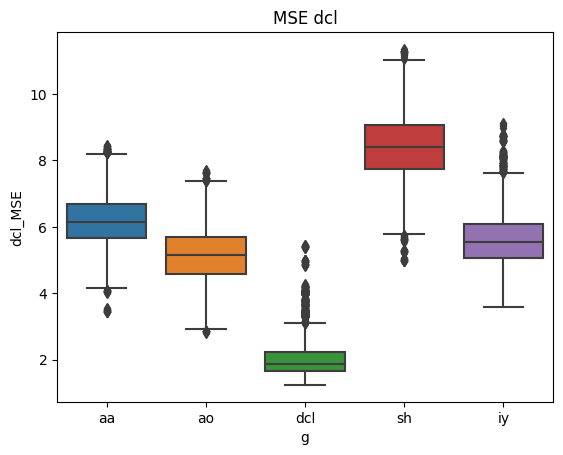

<Axes: xlabel='g', ylabel='sh_MSE'>

Text(0.5, 1.0, 'MSE sh')

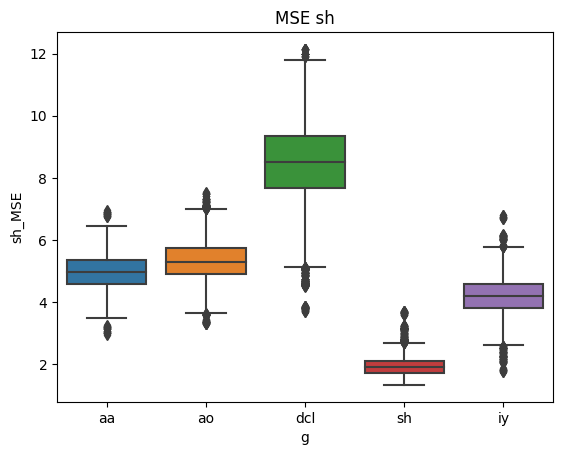

<Axes: xlabel='g', ylabel='iy_MSE'>

Text(0.5, 1.0, 'MSE iy')

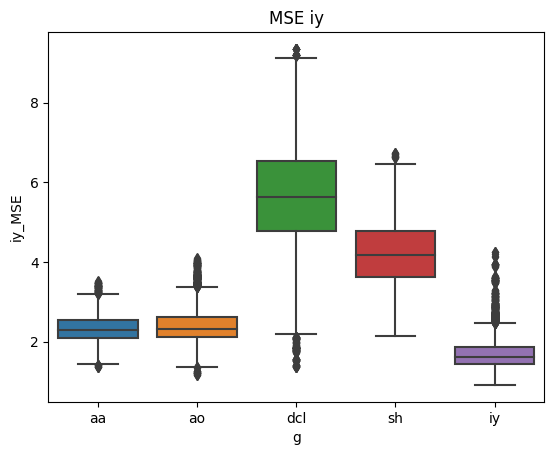

In [ ]:
#@title

# This code is specifically to generate visualizations to aid the description
# it's not used for generating the prediction

avg_signals_speaker_removed = {}

for phoneme in df['g'].unique():
    avg_signals_speaker_removed[phoneme] = periodograms_speaker_removed[df['g'] == phoneme].median(axis=0)

fig, ax = plt.subplots(figsize=((10, 2.5)))

for phoneme in df['g'].unique():
    ax.plot(avg_signals_speaker_removed[phoneme], label=phoneme)
    ax.tick_params(rotation=90)

plt.title('Average Signal Per Phoneme \n Avg Speaker Signal Removed')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

for phoneme in avg_signals_speaker_removed.keys():
    periodograms_speaker_removed[f'{phoneme}_MSE'] = np.mean(np.abs(periodograms_speaker_removed - avg_signals_speaker_removed[phoneme]), axis=1)

for phoneme in avg_signals_speaker_removed.keys():

    sns.boxplot(periodograms_speaker_removed, x=df['g'], y=f'{phoneme}_MSE')
    plt.title(f'MSE {phoneme}')
    plt.show()

Finally we prepreprocess the speaker subtracted signals through PCA with 128 components. We arrived at 128 componenets by doing gridsearch through `range(16, 256, 32)`. After running PCA on the `(x1, x2, ..., x256)` features we append the `MSE` features to make a final feature set of 128 + 5 = 133 features.

## Things that were tried but didn't work

* Scaling the features with sandardscalar and removing outliers reduced accuracy to 0.69
```
scaler = StandardScaler()
tX0_scaled = scaler.fit_transform(tX0.select_dtypes(include=np.number))
vX0_scaled = scaler.transform(vX0.select_dtypes(include=np.number))
vX_scaled = scaler.transform(vX.select_dtypes(include=np.number))
z_scores = np.abs(stats.zscore(tX0_scaled))
tX0_scaled = tX0_scaled[(z_scores < 3).all(axis=1)]
tY0 = tY0[(z_scores < 3).all(axis=1)]  # remove outliers from the target variable as well
```

* Outlier removal: second approach

  The idea was to remove samples that were out of distribution. We grouped samples by their respective label. Each feature of each group was treated as a normal distribution. Then, for each sample, we counted how many features were out of distribution (how many features were in the first and last quantile), and if that count was higher than 150 (150 features out of distribution), we removed the sample. This approach didn't lead to improvements in accuracy.

  * * Outlier removal: third approach

  The other idea for outlier removal was through the function outlier_cap. Outlier cap is a function that will apply outlier capping to the upper and lower outer percentiles, which will identify any value outside these thresholds as outliers. The lambda function iterates over each column in the data frame and applies the outlier_cap function to each individually. The new X_train and X_test are then reassigned. We tested with different thresholds of .01, .02, .025 and further. After experimenting with different percentiles, we agreed that the function was not appropriate for the type of problem being addressed. The function resulted in a lower performance during testing. After thinking about the underlying principles when dealing with phonemes, the spikes and drops in 'g' during each pronounciation are most likely key indicators of the actual sound being made. This is most likely why the removed values towards the higher thresholds resulted in a marginally worse performance (between a -.005 and -.015 drop in performance.




**Student's answer:**

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier

df = pd.read_csv('XY_Phonemes.csv')
periodograms = df.drop(['g', 'SpkrID'], axis=1)

# get the average speaker signal
avg_speaker = {}
for spkr in df['SpkrID'].unique():
    avg_speaker[spkr] = periodograms[df['SpkrID'] == spkr].median(axis=0)

del periodograms

# divide data into train and test
test_spkr = df.query('g!=g')['SpkrID']
test_data = df.query('g!=g').drop(['g', 'SpkrID'], axis=1)

train_targets =  df.query('g==g')['g']
train_spkr = df.query('g==g')['SpkrID']
train_data = df.query('g==g').drop(['g', 'SpkrID'], axis=1)

# process train and test data by removing speaker effect from each periodogram
for spkr in avg_speaker.keys():
    train_data[train_spkr == spkr] -= avg_speaker[spkr]
    test_data[test_spkr == spkr] -= avg_speaker[spkr]

# get the average signal for each phoneme
avg_signals_speaker_removed = {}
for phoneme in train_targets.unique():
    avg_signals_speaker_removed[phoneme] = train_data[train_targets == phoneme].median(axis=0)

# add new MSE features to the train and test data
# measures how well each signal matches the reference signal that we calculated above
for phoneme in avg_signals_speaker_removed.keys():
    train_data[f'{phoneme}_MSE'] = np.mean((train_data - avg_signals_speaker_removed[phoneme]) ** 2, axis=1)
    test_data[f'{phoneme}_MSE'] = np.mean((test_data - avg_signals_speaker_removed[phoneme]) ** 2, axis=1)

# we only want to use PCA on the signal data not the MSE or categorical data
pca_cols = [col for col in train_data.columns if 'MSE' not in col]
nonpca_cols = [col for col in train_data.columns if 'MSE' in col]

# PCA transform
pca = PCA(n_components=128)
train_pca = pca.fit_transform(train_data[pca_cols])
test_pca = pca.transform(test_data[pca_cols])

# combined the PCA features back with the non-PCA features
train_data = np.hstack((train_pca, train_data[nonpca_cols].values))
test_data = np.hstack((test_pca, test_data[nonpca_cols].values))

<ipython-input-12-92dd811ff17f>:7: DtypeWarning: Columns (257) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('XY_Phonemes.csv')


## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

The submission is an XGBoost gradient boosting classifier. We settled on this model by comparing a few different candidate models after the preprocessing was solidified. We compared `RandomForest`, `Regression`, `LDA`, `SVM`, `Cubic spline regression` and `XGBoost`. We compared each model's default parameters, except for cubic spline regression which explored several numbers of knots. In the end `XGBoost` performed best. The effectiveness of each model was measured by accuracy as that was our estimate of what the leaderboard is calculating.

After deciding on `XGBoost` the parameters were tuned via gridsearch.

**Student's answer:**

In [ ]:
clf = XGBClassifier(
    eval_metric='mlogloss',
    n_estimators=500,  # Increase the number of trees
    learning_rate=0.1,  # Decrease the learning rate
    max_depth=5,  # Increase the maximum depth of the trees
    min_child_weight=1,  # Increase the minimum child weight
    gamma=0,  # Increase the minimum loss reduction required to make a split
    subsample=0.8,  # Increase the subsample ratio of the training instances
    colsample_bytree=0.8,  # Increase the subsample ratio of columns when constructing each tree
    scale_pos_weight=1,  # Increase the balance of positive and negative weights
    seed=27,  # Set a random seed for reproducibility
    tree_method='gpu_hist'
)

lblr = LabelEncoder()

clf.fit(train_data, lblr.fit_transform(train_targets))

predictions = lblr.inverse_transform(clf.predict(test_data))

pred_df = pd.DataFrame(predictions, index=range(1,len(predictions)+1), columns=['g'])
pred_df.to_csv('predictions_xgboost_median-signal_pca128.csv', index_label='id')

[00:54:22] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

# **References:**

1. Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".

2. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

3. Wikipedia: Peridogram. (2004, July 22). FL: Wikimedia Foundation, Inc. Retrieved June 25, 2023, from https://en.wikipedia.org/wiki/Periodogram

4. Hastie, T., Tibshirani, R., Friedman, J. H., & Friedman, J. H. (2009). The elements of statistical learning: data mining, inference, and prediction (Vol. 2, pp. 1-758). New York: springer.

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 21 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and/or incorporating speaker ID. For example, you could scale/transform each speaker's observations separately.
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Check difference in distribution between test and train data. You might consider [group k-fold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for testing locally or your model will memorize user-phoneme releation, instead of phoneme attributes and class.
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 1. Additional info:
    1. Harmonics: [wiki](https://en.wikipedia.org/wiki/Harmonic), [sinusoidal regression](https://www.youtube.com/results?search_query=regression+sinusoidal)
    1. Discrete Fourier Transofrm (DFT): [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [Steve Brunton @UW](https://www.youtube.com/watch?v=nl9TZanwbBk), [YouTube search](https://www.youtube.com/results?search_query=Discrete+Fourier+transform)
    1. Spectral density estimation [(wiki)](https://en.wikipedia.org/wiki/Spectral_density_estimation), [YouTube search](https://www.youtube.com/results?search_query=spectral+density+estimation)


